In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import json
import warnings
from matplotlib import pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
region = pd.read_csv('../data/kms_new/법정동주소코드.csv', sep="|")

In [7]:
region_right = region[['법정동번호', '시도기본', '구군', '행정동', '투기지역여부', '투기과열지구여부', '조정대상지역여부']]

In [8]:
df = pd.read_csv('../data/kms_new/단지기본정보.csv', sep='|', low_memory=False)

# 단지기본정보 필요한 데이터들 정제하면서 보기

In [9]:
df['건물유형'].unique()

array(['아파트', '주상복합', '오피스텔', '재개발', '생활숙박시설'], dtype=object)

### 건물유형 걸러내기

In [10]:
# 오피스텔 제외
df.drop(df[df['건물유형'] == '오피스텔'].index, inplace=True)

In [11]:
# 재개발 지역 제외
df.drop(df[df['건물유형'] == '재개발'].index, inplace=True)

In [12]:
# 생활형숙박시설 제외
df.drop(df[df['건물유형'] == '생활숙박시설'].index, inplace=True)

In [13]:
# 도시형 생활주택 4142개 포함해야 되는지 확인 필요
df[df['도시형여부']=='Y'].groupby('건물유형').count()['단지코드']

건물유형
아파트     1880
주상복합    2293
Name: 단지코드, dtype: int64

### 세대수 정보 정리

In [14]:
# 토탈세대수 0 인 애들이 3채 - 데이터 열어보니 재건축인데 아파트로 들어가 있음. 지워버려
print(df[df['토탈총세대수'] == 0]['단지구역명'])
df.drop(df[df['토탈총세대수'] == 0].index, inplace=True)

49247     북가좌제6구역
49317       남산1구역
49349    대치구마을3지구
Name: 단지구역명, dtype: object


세대수 작은 단지들 문제없는건지 다시 한번 볼 필요성 있음

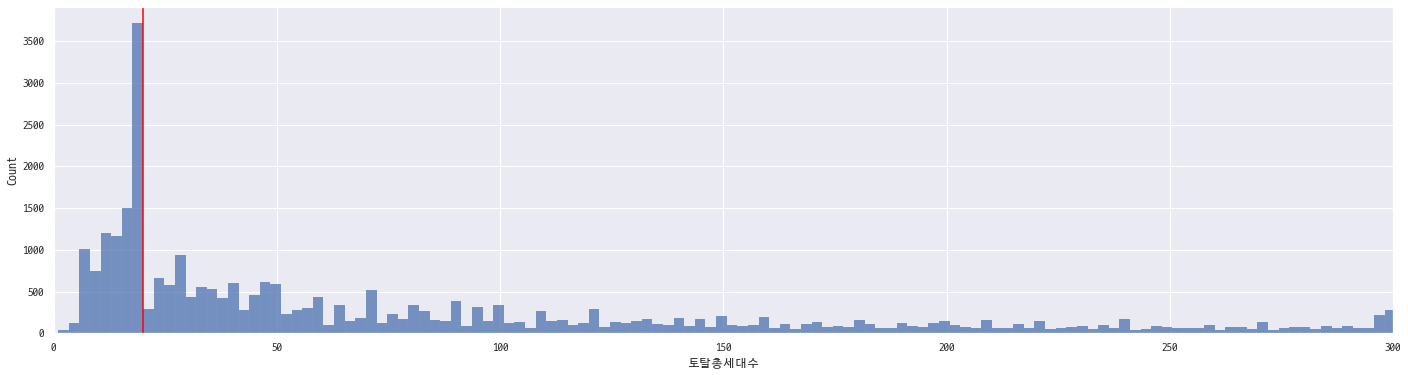

In [15]:
# 우리나라 아파트가 이렇게 세대수가 작은게 많다고?
sns.set(rc={'figure.figsize': (24, 6), 'font.family': 'D2Coding'})
p = sns.histplot(df['토탈총세대수'], bins=4000)
#p = sns.histplot(df[df['도시형여부'] != 'Y']['토탈총세대수'], bins=4000)
p.set_xlim(0, 300)
plt.axvline(x=20, color='red')
plt.show()

In [16]:
df['토탈총세대수'].describe()

count    42726.000000
mean       271.523662
std        408.643002
min          1.000000
25%         26.000000
50%         98.000000
75%        374.000000
max       9510.000000
Name: 토탈총세대수, dtype: float64

In [17]:
# 예상총세대수는 뭐지? 값있는애들이 별로 없다. - 재건축만 있어야될거 같은데 아닌 경우도 있고, 일반 총세대수랑 똑같은경우도 있고 알수없음.
df[df['예상총세대수'] > 0].count()['단지코드']
#df[df['예상총세대수'] > 0].to_csv('expected_house.csv', encoding="utf-8-sig")

488

In [18]:
# 토탈총세대수는 총세대수 + 임대총세대수 인데, 이게 값이 이상한 녀석들 있음. - 일단 많지 않아서 국토부세대수가 토탈총세대수보다 많은 경우 그냥 강제 조정함.
temp = df[df['토탈총세대수'] != df['총세대수'] + df['임대총세대수']]
temp = temp[['토탈총세대수', '총세대수', '일반분양세대수', '국토부세대수', '임대총세대수']]
temp.loc[temp['국토부세대수'] > temp['토탈총세대수'], '토탈총세대수'] = temp['국토부세대수']
df.update(temp, join='left', overwrite=True) # 일단 임대아파트 보다도 작게 들어간거 수정

### 주차대수 문제
세대당 주차대수 결측치 너무 많은데(7048개), 이거를 그냥 일괄로 메울지 아니면 뭔가 추정할만한 다른 방법 찾을지?


In [19]:
# 주차대수 정보가 없는 단지가 7048개나됨. 큰단지 작은단지 오래되거나 새 아파트까지 대중이 없음. 버리기에도 너무 아깝고...
df[df['세대당주차대수'] == 0].count()['총주차대수']

7048

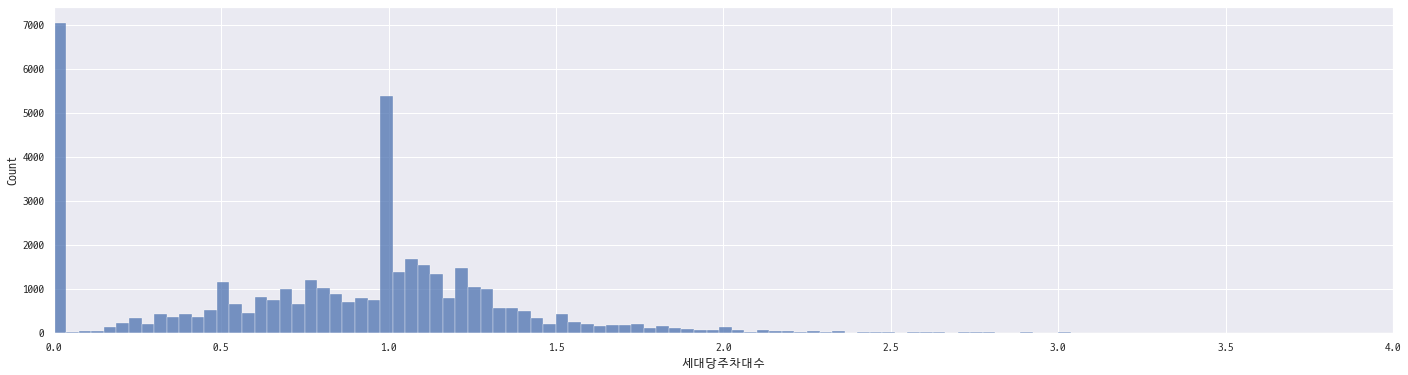

In [20]:
# 세대당주차대수는 0인 경우 그냥 1.0으로 일단 메워버리고, 신축인 경우 조금씩 높게 잡아?
sns.set(rc={'figure.figsize': (24, 6), 'font.family': 'D2Coding'})
p = sns.histplot(df['세대당주차대수'], bins=400)
p.set_xlim(0, 4)
#plt.axvline(x=20, color='red')
plt.show()

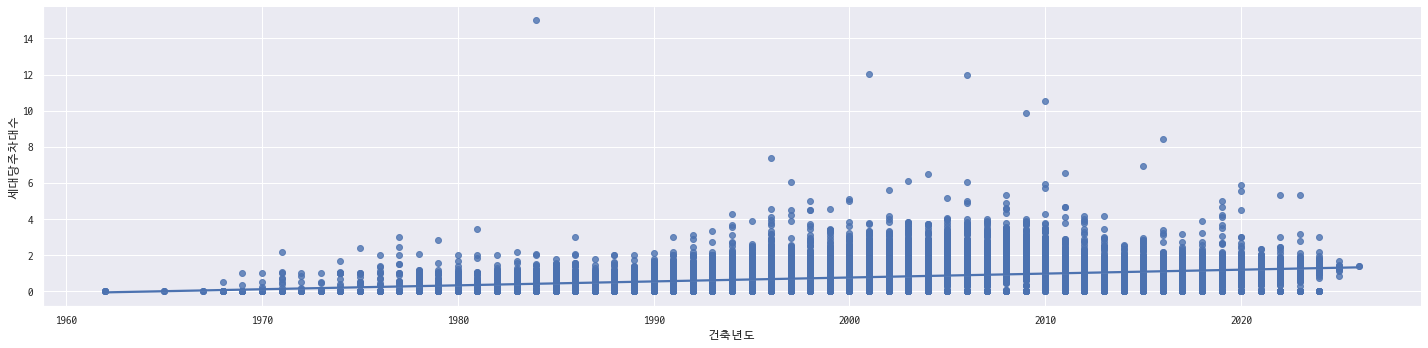

In [21]:
g = sns.lmplot(x='건축년도', y='세대당주차대수', data=df[df['건축년도']>1960], aspect=4.0)
plt.show()

In [22]:
# 세대당주차대수 너무 많은 이상치들 있음 - 56개 정도.
print(df[df['세대당주차대수'] > 4].count()['세대당주차대수'])

# 주상복합이 주로 많고, 이외에는 아파트 세대수가 매우작거나 한남동 청당동 같은데 고급 아파트인듯...
for name in df[(df['세대당주차대수'] > 4) & (df['건물유형'] != '주상복합')]['단지구역명'].to_list(): print(name, end=' ')

56
삼성서초가든스위트 용산아이피아대주피오레 대진 낙원 트라움하우스3차 트라움하우스5차 용인보라우남퍼스트빌리젠트 장충상지리츠빌카일룸 한남라테라스 청담마크노빌 코번하우스 효성청담101 스마트빌(도시형) 청담어퍼하우스 나인원한남 청담브르넨 에테르노청담 두산 PH129 장학파르크한남 빌라드그리움L 효성청담101 2차 

주차대수 과잉으로 잡히는 경우가 많음. 오피스텔과 아파트 같이 있는 경우, 아파트가 도시형이랑 따로 등기되있는 경우 주차장으로 중복으로 잡아가지고 문제가 있음.

In [23]:
# 심한 이상치 중에 주상복합 등 판단 안되는거 말고 누가봐도 잘못들어간거 하나 수정함.
print(df[df['세대당주차대수'] > 6]['단지구역명'])
df.loc[18541, '세대당주차대수'] /= 10
df.loc[18300, '세대당주차대수'] /= 10

# 오피스텔 세대 대부분인데 주차 공유인데 다 아파트로 들어간듯
df.loc[13984, '세대당주차대수'] = 1.2 
df.loc[46762, '세대당주차대수'] = 1.0
df.loc[31308, '세대당주차대수'] = 1.1

194               S-타워
1272         삼성보라매옴니타워
12357          리버마이다스빌
13984          마포트라팰리스
15934        롯데캐슬프레지던트
15940         도곡푸르지오2차
18300               대진
18541               낙원
20913         트라움하우스5차
21621          코업스타클래스
22024           갤러리아포레
31308    부용한웅드리머스(도시형)
46762        스마트빌(도시형)
Name: 단지구역명, dtype: object


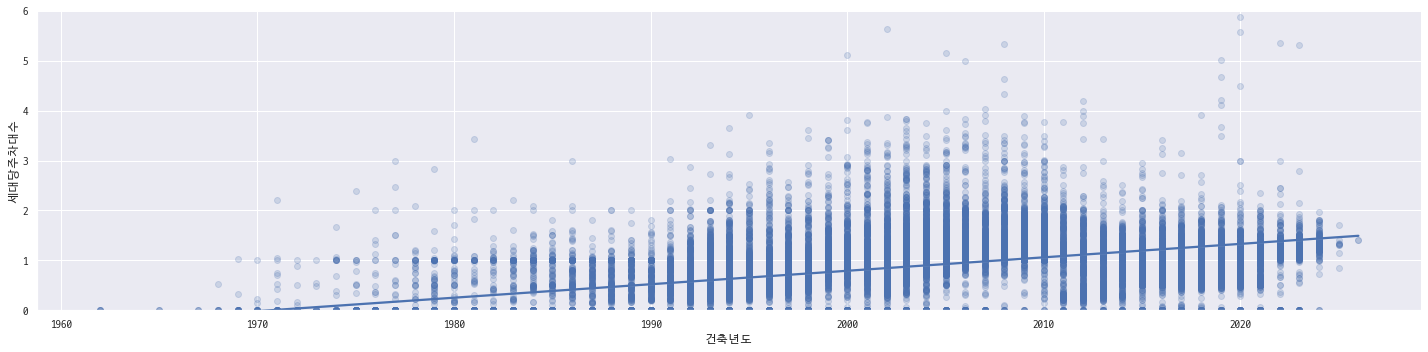

In [24]:
g = sns.lmplot(x='건축년도', y='세대당주차대수', data=df[(df['건축년도']>1960)&(df['건물유형']=='아파트')], aspect=4.0, scatter_kws={"alpha":0.2})
g.set(ylim=(0, 6))
plt.show()

In [25]:
# 일단 데이터 만들고 이후에 조금더 정밀하게 세대당주차대수 회귀 만들기
#df.loc[df['세대당주차대수'] == 0, '세대당주차대수'] = 1.0

### 연도 정리

In [26]:
# 건축년도 비어있는게 62개 정도됨 - 어떻게 임의로 메울 방법도 없음. 입주년도 있는 경우 빼고는
df[df['건축년도'].isnull()].count()['단지코드']
#df[df['건축년도'].isnull()].to_csv('no_construction_year.csv', encoding="utf-8-sig")

62

In [27]:
# 입주년도가 비어있는 경우는 138개
df[df['입주년도'].isnull()].count()['단지코드']

138

In [28]:
# 건축년도랑 입주년도가 보통 같게 들어가 있는데, 이게 아닌 경우에 둘중에 하나가 빠른 경우가 두가지 경우가 다 존재하는데, 이게 말이 되는건가....
df[df['건축년도'] < df['입주년도']][['건축년도', '입주년도']]

,건축년도,입주년도
90,1978.0,1979.0
112,1980.0,1981.0
137,1987.0,1988.0
166,1996.0,1998.0
192,1991.0,1992.0
...,...,...
51268,2020.0,2021.0
51384,2016.0,2019.0
52794,2002.0,2020.0
52870,2020.0,2021.0


In [29]:
df[df['건축년도'] > df['입주년도']][['건축년도', '입주년도']]

,건축년도,입주년도
61,2012.0,2011.0
67,1983.0,1982.0
70,1995.0,1992.0
76,1997.0,1996.0
85,2003.0,2002.0
...,...,...
49881,2017.0,2014.0
51387,2011.0,2010.0
52319,2021.0,2012.0
54324,2021.0,2012.0


### 그외 기본정보 데이터 일부 확인

In [30]:
# 최고층 최저층이 의미 있는지 모르겠지만 ... 최저층 -1 도 있네...
print(df[df['최저층'] < 0]['단지구역명'])
df[['최고층', '최저층']].describe()

33777    마포킹덤힐
Name: 단지구역명, dtype: object


,최고층,최저층
count,42726.000000,42726.000000
mean,13.156603,10.301549
std,7.831982,5.954151
min,0.000000,-1.000000
25%,6.000000,6.000000
50%,12.000000,9.000000
75%,18.000000,14.000000
max,84.000000,84.000000


In [31]:
# 방향은 죄다 남향이라고 되어 있거나, nan이라서 의미없음.
print(df.groupby('방향').count()['단지코드'])
df.drop('방향', axis=1, inplace=True)

방향
남동향        3
남서향        3
남향     20523
동향         4
북동향        1
서향         2
Name: 단지코드, dtype: int64


In [32]:
# 녹지율 전부 NaN 아니면 0이어서 사실상 의미없는 데이터
print("녹지율이 NaN인 경우: {}개, 녹지율이 0인 경우: {}개".format(df[df['녹지율'].isnull()].count()['단지코드'], df[df['녹지율'] == 0].count()['단지코드']))
print("전체 데이터의 {:.2f}".format(42148 / 42726))

녹지율이 NaN인 경우: 34476개, 녹지율이 0인 경우: 7732개
전체 데이터의 0.99


In [33]:
# 승강기대수도 전혀 의미없는 컬럼
df.groupby('승강기대수').count()['단지코드']

승강기대수
0.0     13981
1.0        30
2.0         9
3.0         5
4.0         2
5.0         1
7.0         1
10.0        1
30.0        1
78.0        1
Name: 단지코드, dtype: int64

In [34]:
# 국민은행 사용하는 데이터는 막상 2985개뿐 ?
df.groupby('국민은행사용여부').count()['단지코드']
#df[df['국민은행사용여부'] == 'N'].to_csv('KB_use.csv', encoding="utf-8-sig")

국민은행사용여부
N    39741
Y     2985
Name: 단지코드, dtype: int64

In [35]:
# 단지조사레벨이 뭔지 모르지만 어디까지 조사했나??? 이런거???
df.groupby('단지조사레벨').count()['단지코드']

단지조사레벨
0      324
1     2318
2      545
3    38950
4       92
5       74
6      306
8       66
9       51
Name: 단지코드, dtype: int64

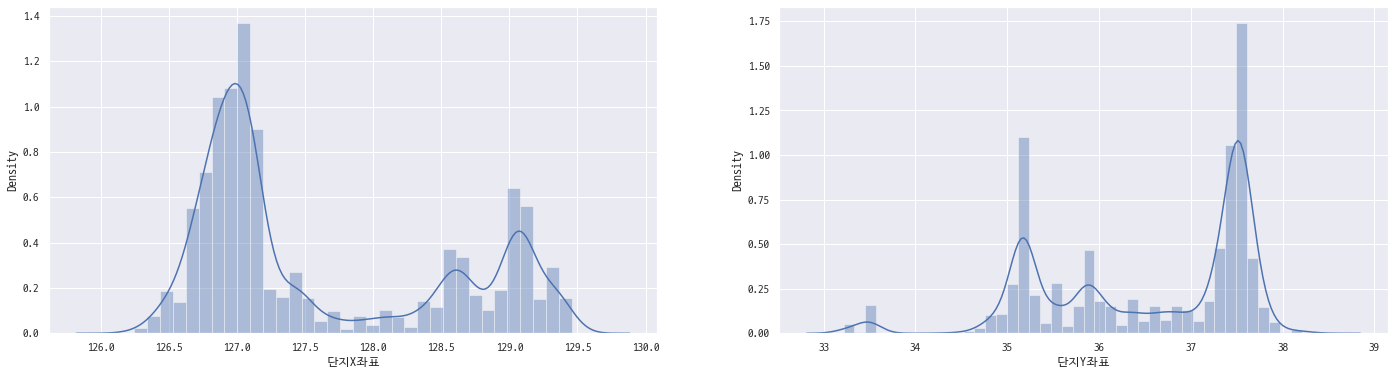

In [36]:
# 좌표는 맞게 있는듯함... 일단 다행히
fig, ax = plt.subplots(1, 2)
sns.distplot(df['단지X좌표'], ax=ax[0])
sns.distplot(df['단지Y좌표'], ax=ax[1])
plt.show()

# 최종 기본정보 테이블에서 쓸만하고 필요한 컬럼 

In [42]:
df_left = df[['단지코드', '법정동번호', '상세지번', '도시형여부', '신도시뉴타운명', '지구명', '브랜드명', '단지구역명', '단지구역명1', '토탈총세대수', '임대구분', '임대총세대수', '세대당주차대수', '건축년도', '입주년도', '최고층', '최저층', '난방방식', '단지조사레벨', '단지X좌표', '단지Y좌표']]

In [38]:
tf = pd.merge(df_left, region_right, how='left', on='법정동번호')

In [39]:
tf.set_index('단지코드', inplace=True)

In [52]:
# y and n to boolean
tf.replace({'N': "false", 'Y': "true"}, inplace=True)
tf[['토탈총세대수', '임대총세대수', '임대구분', '건축년도', '입주년도', '최고층', '최저층']].astype('float')

,토탈총세대수,임대총세대수,임대구분,건축년도,입주년도,최고층,최저층
단지코드,,,,,,,
1,548.0,0.0,1.0,1986.0,1986.0,14.0,12.0
3,644.0,0.0,1.0,1997.0,1997.0,13.0,9.0
4,60.0,0.0,1.0,1996.0,1996.0,8.0,6.0
5,111.0,0.0,1.0,1996.0,1996.0,12.0,9.0
6,70.0,0.0,1.0,1976.0,1976.0,5.0,5.0
...,...,...,...,...,...,...,...
225977,78.0,0.0,1.0,2021.0,2021.0,15.0,15.0
225978,16.0,0.0,1.0,2021.0,2021.0,5.0,5.0
225979,14.0,0.0,1.0,2021.0,2021.0,6.0,3.0


In [87]:
tf.to_csv("recommend_table_1.csv", encoding="utf-8-sig")
#tf.to_pickle("recommend_table_v1.0.pkl")

In [90]:
tf[tf.index.isin([25937, 25939])]

,법정동번호,상세지번,도시형여부,신도시뉴타운명,지구명,브랜드명,단지구역명,단지구역명1,토탈총세대수,임대구분,...,난방방식,단지조사레벨,단지X좌표,단지Y좌표,시도기본,구군,행정동,투기지역여부,투기과열지구여부,조정대상지역여부
단지코드,,,,,,,,,,,,,,,,,,,,,
25937,2174,761,False,군포역세권뉴타운,용현.학익지구,굿모닝힐,수원화서역동문굿모닝힐,,293.0,1.0,...,지역난방,3,126.994857,37.284710,경기도,수원시 팔달구,화서1동,False,True,True
25939,3070,426,False,군포역세권뉴타운,용현.학익지구,굿모닝힐,에버랜드,,50.0,1.0,...,개별난방,3,127.190348,37.237405,경기도,용인시 처인구,역삼동,False,False,True
